# Hybrid Diagnostic Decision Support System for Mental Health Assessment

**Module:** Foundations of AI  
**Deadline:** 5th January 2026

---

## Project Overview

This notebook implements a **Category 3 Hybrid Approach** combining:
- **Symbolic reasoning** (Prolog expert system) for objective diagnostic criteria
- **Stochastic methods** (LLM) for knowledge extraction and subjective assessment

### Architecture

```
Layer 1: Knowledge Base Construction (LLM → Prolog)
    DSM-5 Text → LLM Extraction → Prolog Rules
                     ↓
Layer 2: Three-Tier Diagnostic Reasoning
    Tier A: Objective (Prolog) - symptom counts, duration, onset
    Tier B: Subjective (LLM) - clinical significance, severity
    Tier C: Integration (Prolog) - ranked diagnoses + explanations
                     ↓
Layer 3: Diagnostic Pathway Search (A*)
    Optimised question ordering with branch pruning
```

### Target Disorders

| Disorder | Key Challenge | Complexity |
|----------|---------------|------------|
| MDD | Count-based (5/9), 2-week duration | Medium |
| GAD | Subjective "excessive worry" | Medium |
| ADHD | Onset before 12, dual domains | High |
| PTSD | Trauma criterion, symptom clusters | High |
| ASD | Severity levels, developmental history | High |

# ⚠️ DEPRECATION NOTICE ⚠️

**This notebook has been archived as of 2026-01-01.**

## Migration Guide

**Code Migration Map:**
- `PrologEngine` class → `src/reasoning/engine.py`
- `explore_disorder()` → `src/reasoning/utils.py`
- Diagnostic flowchart viz → `src/reasoning/viz.py`
- Patient case management → `src/search/manager.SessionManager`
- A* search → `src/search/search.DiagnosticSearch`
- Evaluation → `src/evaluation/benchmark.py`

**Documentation:** See `/docs/` for comprehensive guides

**Interactive use:**
```bash
cd src/prolog && swipl -g "[schema], ['gold_standard/loader']"
# Or Python REPL:
from src.reasoning import PrologEngine
engine = PrologEngine(Path('src/prolog'))
```

**See:** [Getting Started Guide](../docs/GETTING_STARTED.md) | [API Reference](../docs/API_REFERENCE.md)

---

---

## 1. Environment Setup

### 1.1 Imports and Configuration

We use **pyswip** to interface Python with SWI-Prolog. This allows us to:
- Load Prolog knowledge bases
- Assert patient facts dynamically
- Query diagnostic rules and retrieve explanations

**Design Decision:** We chose pyswip over alternatives like janus because:
- Better documentation and community support
- Simpler API for our use case
- Compatible with SWI-Prolog 9.x

In [61]:
# Standard library
import os
import sys
import json
from pathlib import Path
from typing import Dict, List, Optional, Tuple, Any
from dataclasses import dataclass, field
from enum import Enum

# Project paths - must be set before importing src modules
PROJECT_ROOT = Path('../').resolve()
PROLOG_DIR = PROJECT_ROOT / 'src' / 'prolog'
DATA_DIR = PROJECT_ROOT / 'data'
DSM5_TEXT_DIR = DATA_DIR / 'dsm5_text'
VIGNETTES_DIR = DATA_DIR / 'vignettes'

# Add project root to path for src imports
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

# Data processing
import pandas as pd
import numpy as np

# Visualisation
import matplotlib.pyplot as plt
import networkx as nx

# Prolog interface
from pyswip import Prolog

# Progress bars
from tqdm.notebook import tqdm

print(f"Project root: {PROJECT_ROOT}")
print(f"Prolog directory: {PROLOG_DIR}")
print(f"sys.path includes project root: {str(PROJECT_ROOT) in sys.path}")

Project root: /Users/alfieroberts/Documents/Applied AI MSc/Coursework/Foundations of AI
Prolog directory: /Users/alfieroberts/Documents/Applied AI MSc/Coursework/Foundations of AI/src/prolog
sys.path includes project root: True


### 1.2 Prolog Engine Initialisation

We create a wrapper class around pyswip's Prolog interface to:
- Handle file path resolution
- Provide cleaner query methods
- Manage patient fact assertions/retractions

**Design Decision:** Wrapping pyswip rather than using it directly provides:
- Consistent error handling
- Easier testing and mocking
- Cleaner separation between Python and Prolog concerns

In [62]:
class PrologEngine:
    """Wrapper around pyswip Prolog for diagnostic reasoning."""
    
    def __init__(self, prolog_dir: Path):
        self.prolog = Prolog()
        self.prolog_dir = prolog_dir
        self._loaded_files = set()
    
    def load_file(self, filename: str) -> bool:
        """Load a Prolog file from the prolog directory."""
        filepath = self.prolog_dir / filename
        if not filepath.exists():
            print(f"Error: File not found: {filepath}")
            return False
        
        try:
            # pyswip requires forward slashes even on Windows
            prolog_path = str(filepath).replace('\\', '/')
            self.prolog.consult(prolog_path)
            self._loaded_files.add(filename)
            print(f"Loaded: {filename}")
            return True
        except Exception as e:
            print(f"Error loading {filename}: {e}")
            return False
    
    def query(self, query_str: str) -> List[Dict]:
        """Execute a Prolog query and return results as list of dicts."""
        try:
            results = list(self.prolog.query(query_str))
            return results
        except Exception as e:
            print(f"Query error: {e}")
            return []
    
    def query_one(self, query_str: str) -> Optional[Dict]:
        """Execute a query and return first result or None."""
        results = self.query(query_str)
        return results[0] if results else None
    
    def assert_fact(self, fact: str) -> bool:
        """Assert a fact into the Prolog knowledge base."""
        try:
            list(self.prolog.query(f"assertz({fact})"))
            return True
        except Exception as e:
            print(f"Assert error: {e}")
            return False
    
    def retract_all(self, pattern: str) -> bool:
        """Retract all facts matching a pattern."""
        try:
            list(self.prolog.query(f"retractall({pattern})"))
            return True
        except Exception as e:
            print(f"Retract error: {e}")
            return False

### 1.3 Load Schema and Gold Standard

We load:
1. **schema.pl** - Core predicate definitions and diagnostic inference rules
2. **gold_standard/loader.pl** - Hand-coded disorder criteria (ground truth)

The gold standard serves two purposes:
- Validation target for LLM extraction accuracy
- Fallback knowledge base if extraction quality is insufficient

In [63]:
# Initialise Prolog engine
engine = PrologEngine(PROLOG_DIR)

# Load schema and gold standard
engine.load_file('schema.pl')
engine.load_file('gold_standard/loader.pl')

Loaded: schema.pl
Loaded: mdd
Loaded: gad
Loaded: adhd
Loaded: ptsd
Loaded: gold_standard/loader.pl


True

### 1.4 Verify Knowledge Base

Quick sanity check to ensure the knowledge base loaded correctly.

In [64]:
# List all loaded disorders
disorders = engine.query("disorder(ID, Name, Category)")
print("Loaded Disorders:")
for d in disorders:
    print(f"  - {d['ID']}: {d['Name']} ({d['Category']})")

# Count symptoms per disorder
print("\nSymptom Counts:")
for d in disorders:
    disorder_id = d['ID']
    symptoms = engine.query(f"symptom({disorder_id}, SID, Cat, Desc)")
    print(f"  - {disorder_id}: {len(symptoms)} symptoms")

Loaded Disorders:
  - mdd: Major Depressive Disorder (depressive_disorders)
  - gad: Generalized Anxiety Disorder (anxiety_disorders)
  - adhd: Attention-Deficit/Hyperactivity Disorder (neurodevelopmental_disorders)
  - ptsd: Posttraumatic Stress Disorder (trauma_stressor_related)

Symptom Counts:
  - mdd: 9 symptoms
  - gad: 8 symptoms
  - adhd: 18 symptoms
  - ptsd: 43 symptoms


---

## 2. Knowledge Base Exploration

### 2.1 Schema Structure

The Prolog schema defines the following predicate types:

| Predicate | Arity | Purpose |
|-----------|-------|----------|
| `disorder/3` | ID, Name, Category | Disorder definitions |
| `symptom/4` | DisorderID, SymptomID, Category, Description | Individual symptoms |
| `symptom_category/5` | DisorderID, CategoryID, SymptomList, Count, Type | Grouping requirements |
| `duration_requirement/3` | DisorderID, Duration, Unit | Time constraints |
| `onset_requirement/3` | DisorderID, Type, Value | Onset constraints |
| `exclusion_criterion/4` | DisorderID, ExclusionID, Type, Description | What must NOT be present |
| `subjective_criterion/4` | DisorderID, CriterionID, Description, Type | Requires clinical judgment |
| `specifier/4` | DisorderID, Type, Options, Description | Diagnosis qualifiers |

In [65]:
def explore_disorder(engine: PrologEngine, disorder_id: str) -> Dict:
    """Extract all knowledge about a disorder from the KB."""
    return {
        'disorder': engine.query_one(f"disorder({disorder_id}, Name, Category)"),
        'symptoms': engine.query(f"symptom({disorder_id}, SID, Cat, Desc)"),
        'symptom_categories': engine.query(f"symptom_category({disorder_id}, CatID, Symptoms, Count, Type)"),
        'duration': engine.query_one(f"duration_requirement({disorder_id}, Dur, Unit)"),
        'onset': engine.query_one(f"onset_requirement({disorder_id}, Type, Value)"),
        'exclusions': engine.query(f"exclusion_criterion({disorder_id}, ExcID, Type, Desc)"),
        'subjective': engine.query(f"subjective_criterion({disorder_id}, CritID, Desc, Type)"),
        'specifiers': engine.query(f"specifier({disorder_id}, Type, Options, Desc)")
    }

# Explore MDD
mdd_kb = explore_disorder(engine, 'mdd')
print("MDD Knowledge Base Summary:")
print(f"  Symptoms: {len(mdd_kb['symptoms'])}")
print(f"  Symptom categories: {len(mdd_kb['symptom_categories'])}")
print(f"  Duration: {mdd_kb['duration']}")
print(f"  Exclusions: {len(mdd_kb['exclusions'])}")
print(f"  Subjective criteria: {len(mdd_kb['subjective'])}")
print(f"  Specifiers: {len(mdd_kb['specifiers'])}")

MDD Knowledge Base Summary:
  Symptoms: 9
  Symptom categories: 2
  Duration: {'Dur': 2, 'Unit': 'weeks'}
  Exclusions: 4
  Subjective criteria: 1
  Specifiers: 5


### 2.2 Visualise Diagnostic Algorithm

The flowchart below illustrates the diagnostic decision process implemented by the Prolog expert system:

1. **Sequential criterion checks** - Each DSM-5 criterion is evaluated as a gate
2. **Early termination** - Failure at any gate rules out the diagnosis
3. **Hybrid integration** - Tier B (LLM) handles subjective clinical significance assessment

**Design Decision:** A flowchart representation was chosen because:
- It directly mirrors the Prolog rule execution flow
- It clearly shows where the hybrid (LLM) component integrates
- It demonstrates the explainability of the system's reasoning

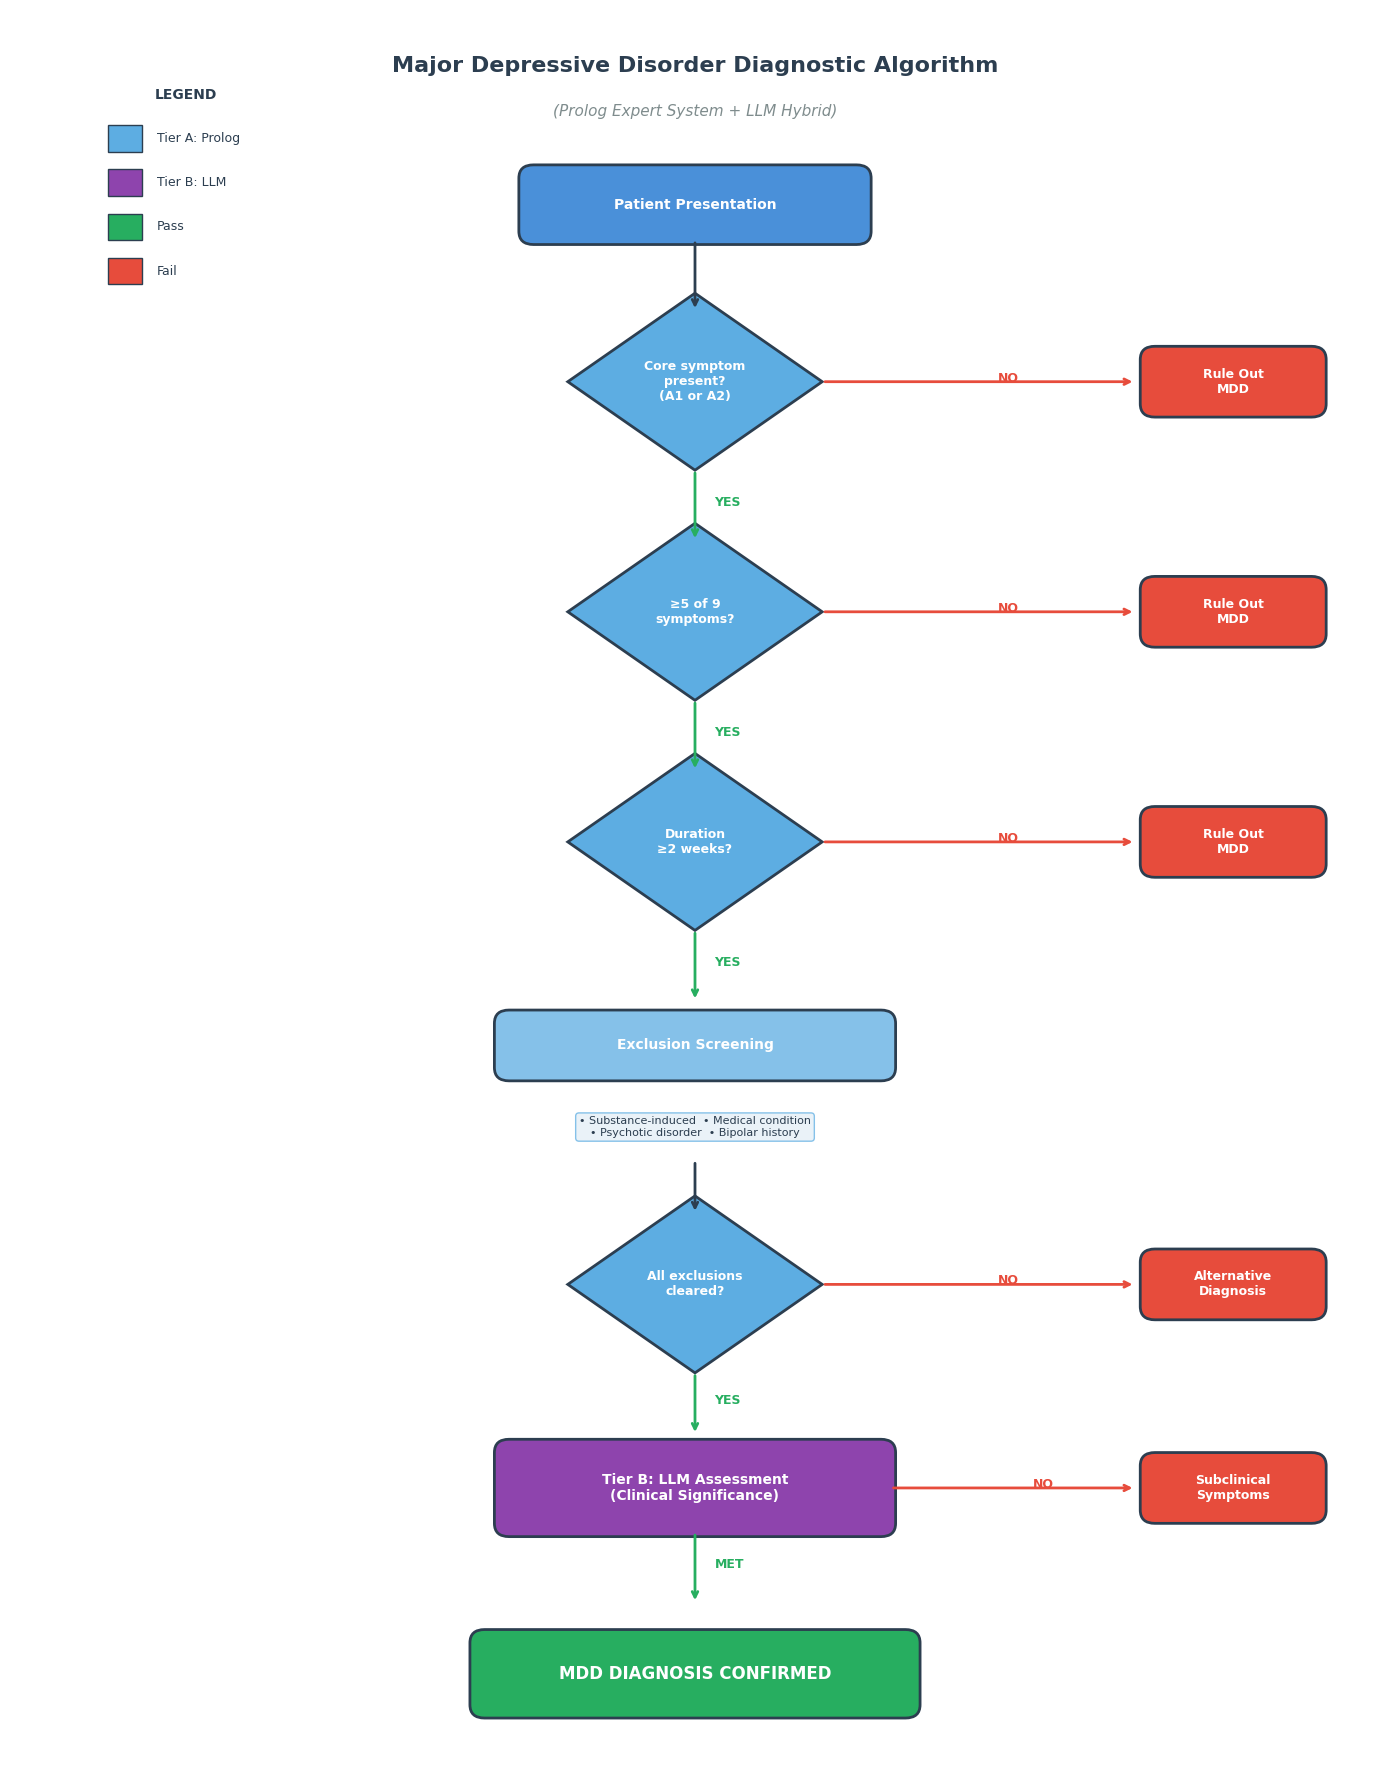

In [66]:
def visualise_diagnostic_flowchart(disorder_id: str, disorder_data: Dict):
    """Visualise the diagnostic process as a decision flowchart."""
    fig, ax = plt.subplots(figsize=(14, 18))
    ax.set_xlim(0, 14)
    ax.set_ylim(-4, 16)
    ax.axis('off')
    
    # Professional color palette
    colors = {
        'input': '#4a90d9',
        'decision': '#5dade2',
        'process': '#85c1e9',
        'success': '#27ae60',
        'failure': '#e74c3c',
        'llm': '#8e44ad',
        'arrow_yes': '#27ae60',
        'arrow_no': '#e74c3c',
    }
    
    def draw_box(x, y, text, color, width=3, height=0.8, fontsize=10):
        from matplotlib.patches import FancyBboxPatch
        box = FancyBboxPatch((x - width/2, y - height/2), width, height,
                             boxstyle="round,pad=0.05,rounding_size=0.15",
                             facecolor=color, edgecolor='#2c3e50', linewidth=2)
        ax.add_patch(box)
        ax.text(x, y, text, ha='center', va='center', fontsize=fontsize,
                fontweight='bold', color='white', zorder=3)
    
    def draw_diamond(x, y, text, color, size=1.0, fontsize=9):
        diamond = plt.Polygon([(x, y+size), (x+size*1.3, y), (x, y-size), (x-size*1.3, y)],
                              facecolor=color, edgecolor='#2c3e50', linewidth=2)
        ax.add_patch(diamond)
        ax.text(x, y, text, ha='center', va='center', fontsize=fontsize,
                fontweight='bold', color='white', zorder=3)
    
    def draw_arrow(x1, y1, x2, y2, color='#2c3e50', label=None):
        ax.annotate('', xy=(x2, y2), xytext=(x1, y1),
                   arrowprops=dict(arrowstyle='->', color=color, lw=2))
        if label:
            mid_x = (x1 + x2) / 2 + 0.2
            mid_y = (y1 + y2) / 2
            ax.text(mid_x, mid_y, label, fontsize=9, color=color, fontweight='bold')
    
    # Center x for main flow
    cx = 7
    
    # Title
    disorder_name = disorder_data['disorder']['Name']
    ax.text(7, 15.3, f"{disorder_name} Diagnostic Algorithm", 
            ha='center', fontsize=16, fontweight='bold', color='#2c3e50')
    ax.text(7, 14.8, "(Prolog Expert System + LLM Hybrid)", 
            ha='center', fontsize=11, fontstyle='italic', color='#7f8c8d')
    
    # ===== LEGEND (top left) =====
    lx, ly = 1.8, 14.5
    ax.text(lx, ly + 0.5, "LEGEND", fontsize=10, fontweight='bold', color='#2c3e50', ha='center')
    
    legend_items = [
        ("Tier A: Prolog", colors['decision']),
        ("Tier B: LLM", colors['llm']),
        ("Pass", colors['success']),
        ("Fail", colors['failure']),
    ]
    for i, (label, color) in enumerate(legend_items):
        ax.add_patch(plt.Rectangle((lx - 0.8, ly - i*0.5 - 0.1), 0.35, 0.3, 
                                   facecolor=color, edgecolor='#2c3e50'))
        ax.text(lx - 0.3, ly - i*0.5 + 0.05, label, fontsize=9, va='center', color='#2c3e50')
    
    # 1. Patient Presentation
    draw_box(cx, 13.8, "Patient Presentation", colors['input'], width=3.5)
    draw_arrow(cx, 13.4, cx, 12.6, '#2c3e50')
    
    # 2. Core symptom check
    draw_diamond(cx, 11.8, "Core symptom\npresent?\n(A1 or A2)", colors['decision'])
    draw_arrow(cx, 10.8, cx, 10.0, colors['arrow_yes'], "YES")
    draw_arrow(cx + 1.3, 11.8, 11.5, 11.8, colors['arrow_no'], "NO")
    draw_box(12.5, 11.8, "Rule Out\nMDD", colors['failure'], width=1.8, height=0.7, fontsize=9)
    
    # 3. Symptom count
    draw_diamond(cx, 9.2, "≥5 of 9\nsymptoms?", colors['decision'])
    draw_arrow(cx, 8.2, cx, 7.4, colors['arrow_yes'], "YES")
    draw_arrow(cx + 1.3, 9.2, 11.5, 9.2, colors['arrow_no'], "NO")
    draw_box(12.5, 9.2, "Rule Out\nMDD", colors['failure'], width=1.8, height=0.7, fontsize=9)
    
    # 4. Duration
    dur = disorder_data['duration']
    dur_text = f"Duration\n≥{dur['Dur']} {dur['Unit']}?" if dur else "Duration\nmet?"
    draw_diamond(cx, 6.6, dur_text, colors['decision'])
    draw_arrow(cx, 5.6, cx, 4.8, colors['arrow_yes'], "YES")
    draw_arrow(cx + 1.3, 6.6, 11.5, 6.6, colors['arrow_no'], "NO")
    draw_box(12.5, 6.6, "Rule Out\nMDD", colors['failure'], width=1.8, height=0.7, fontsize=9)
    
    # 5. Exclusion screening
    draw_box(cx, 4.3, "Exclusion Screening", colors['process'], width=4, height=0.7)
    excl_text = "• Substance-induced  • Medical condition\n• Psychotic disorder  • Bipolar history"
    ax.text(cx, 3.5, excl_text, ha='center', va='top', fontsize=8, color='#2c3e50',
            bbox=dict(boxstyle='round,pad=0.3', facecolor='#eaf2f8', edgecolor='#85c1e9'))
    draw_arrow(cx, 3.0, cx, 2.4, '#2c3e50')
    
    # 6. Exclusions cleared
    draw_diamond(cx, 1.6, "All exclusions\ncleared?", colors['decision'])
    draw_arrow(cx, 0.6, cx, -0.1, colors['arrow_yes'], "YES")
    draw_arrow(cx + 1.3, 1.6, 11.5, 1.6, colors['arrow_no'], "NO")
    draw_box(12.5, 1.6, "Alternative\nDiagnosis", colors['failure'], width=1.8, height=0.7, fontsize=9)
    
    # 7. LLM Assessment (Tier B)
    draw_box(cx, -0.7, "Tier B: LLM Assessment\n(Clinical Significance)", 
             colors['llm'], width=4, height=1, fontsize=10)
    draw_arrow(cx, -1.2, cx, -2.0, colors['arrow_yes'], "MET")
    
    # NOT MET path - consistent red box style
    draw_arrow(cx + 2, -0.7, 11.5, -0.7, colors['arrow_no'], "NO")
    draw_box(12.5, -0.7, "Subclinical\nSymptoms", colors['failure'], width=1.8, height=0.7, fontsize=9)
    
    # 8. Final Diagnosis
    draw_box(cx, -2.8, "MDD DIAGNOSIS CONFIRMED", colors['success'], width=4.5, height=0.9, fontsize=12)
    
    plt.tight_layout()
    plt.show()

# Visualise MDD diagnostic flowchart
visualise_diagnostic_flowchart('mdd', mdd_kb)

---

## 3. LLM Extraction Pipeline

The extraction pipeline converts DSM-5 text into Prolog rules. This is implemented in `src/extraction/` and can be run via CLI or notebook.

```
DSM-5 Text → LLM (with thinking) → Prolog Output → Syntax Validation → Production
```

| Provider | Model | Thinking Parameter |
|----------|-------|-------------------|
| Anthropic | Claude Opus 4.5 | `thinking_budget` (1024+) |
| OpenAI | GPT-5.2 | `reasoning_effort` (none→xhigh) |
| Ollama | llama3.1, gpt-oss | `think` (low/medium/high) |

In [67]:
# Import extraction module
from src.extraction import (
    get_dsm5_text, get_template_guide, get_schema_reference,
    ExtractionResult, evaluate_extraction, print_validation_report
)
from src.extraction.run_extraction import run_extraction

# Show available DSM-5 source texts
print("Available DSM-5 texts for extraction:")
for f in sorted(DSM5_TEXT_DIR.glob("*.txt")):
    print(f"  - {f.stem}")

# Show already extracted disorders
extracted_dir = PROJECT_ROOT / 'src' / 'prolog' / 'extracted'
if extracted_dir.exists() and list(extracted_dir.glob("*.pl")):
    print("\nAlready extracted:")
    for pl_file in sorted(extracted_dir.glob("*.pl")):
        print(f"  - {pl_file.stem}")

Available DSM-5 texts for extraction:
  - ADHD
  - ASD
  - GAD
  - MDD
  - PTSD

Already extracted:
  - asd
  - ptsd


### 3.1 Extract ASD

Run extraction for Autism Spectrum Disorder using Claude Opus 4.5 with extended thinking.

In [68]:
# Extract ASD using Claude Opus 4.5
result = run_extraction(
    disorder_id='asd',
    provider_name='anthropic',
    model='claude-opus-4-5-20251101',
    thinking_budget=15000,
    production=True  # Saves to src/prolog/extracted/asd.pl
)


Extracting: ASD
Provider: anthropic
Thinking Budget: 15000 tokens
Model: claude-opus-4-5-20251101
Starting extraction...

Extraction Result: asd
Provider: anthropic
Model: claude-opus-4-5-20251101
Duration: 67.40s
Tokens: 22062 in / 3510 out

Status: SUCCESS
Syntax Valid: True

No validation issues found.

Production saved: /Users/alfieroberts/Documents/Applied AI MSc/Coursework/Foundations of AI/src/prolog/extracted/asd.pl
Production metadata: /Users/alfieroberts/Documents/Applied AI MSc/Coursework/Foundations of AI/src/prolog/extracted/asd.json


---

## 4. Diagnostic Reasoning Engine

### 4.1 Three-Tier Architecture

The diagnostic engine implements three tiers:

| Tier | Handler | Criteria Type | Method |
|------|---------|---------------|--------|
| A | Prolog | Objective | Rule-based inference |
| B | LLM | Subjective | Clinical judgment with confidence |
| C | Prolog | Integration | Combine A+B for final diagnosis |

**Design Decision:** Separating objective and subjective criteria allows:
- Transparent reasoning chains for objective criteria
- Appropriate uncertainty quantification for subjective criteria
- Clinician override capability for Tier B assessments

In [70]:
class SymptomStatus(Enum):
    """Status of a symptom for a patient."""
    PRESENT = "present"
    ABSENT = "absent"
    UNCLEAR = "unclear"

@dataclass
class PatientSymptom:
    """A symptom observation for a patient."""
    symptom_id: str
    status: SymptomStatus
    evidence: str  # Quote from clinical notes

@dataclass
class SubjectiveAssessment:
    """LLM or clinician assessment of a subjective criterion."""
    criterion_id: str
    assessment: str  # "met", "not_met", "unclear"
    confidence: float  # 0.0 to 1.0
    reasoning: str

@dataclass 
class DiagnosisResult:
    """Result of diagnostic reasoning."""
    disorder_id: str
    disorder_name: str
    is_diagnosed: bool
    confidence: float
    criteria_met: Dict[str, bool]
    explanation: str

### 4.2 Patient Case Manager

Manages patient facts in the Prolog knowledge base:
- Assert symptoms from clinical input
- Track duration and onset information
- Record exclusion status
- Store subjective assessments

In [71]:
class PatientCaseManager:
    """Manages patient facts in the Prolog KB."""
    
    def __init__(self, engine: PrologEngine):
        self.engine = engine
        self.current_patient_id: Optional[str] = None
    
    def clear_patient(self, patient_id: str):
        """Clear all facts for a patient."""
        patterns = [
            f"patient_symptom({patient_id}, _, _, _)",
            f"patient_duration({patient_id}, _, _)",
            f"patient_onset_age({patient_id}, _)",
            f"patient_exclusion_status({patient_id}, _, _)",
            f"subjective_assessment({patient_id}, _, _, _)",
            f"patient_context({patient_id}, _, _)"
        ]
        for pattern in patterns:
            self.engine.retract_all(pattern)
    
    def load_patient(self, patient_id: str, symptoms: List[PatientSymptom],
                     duration_days: Dict[str, int],
                     onset_age: Optional[int] = None):
        """Load a patient case into the KB."""
        self.clear_patient(patient_id)
        self.current_patient_id = patient_id
        
        # Assert symptoms
        for sym in symptoms:
            fact = f"patient_symptom({patient_id}, {sym.symptom_id}, {sym.status.value}, '{sym.evidence}')"
            self.engine.assert_fact(fact)
        
        # Assert durations
        for disorder_id, days in duration_days.items():
            fact = f"patient_duration({patient_id}, {disorder_id}, {days})"
            self.engine.assert_fact(fact)
        
        # Assert onset age if provided
        if onset_age is not None:
            fact = f"patient_onset_age({patient_id}, {onset_age})"
            self.engine.assert_fact(fact)
    
    def add_subjective_assessment(self, patient_id: str, assessment: SubjectiveAssessment):
        """Add a subjective assessment to the KB."""
        fact = f"subjective_assessment({patient_id}, {assessment.criterion_id}, {assessment.assessment}, {assessment.confidence})"
        self.engine.assert_fact(fact)

# Initialise patient manager
patient_manager = PatientCaseManager(engine)
print("Patient case manager ready")

Patient case manager ready


### 4.3 Tier A: Objective Reasoning

Queries Prolog for objective criteria evaluation:
- Symptom count requirements
- Duration requirements
- Onset requirements
- Exclusion criteria

In [72]:
class ObjectiveReasoner:
    """Tier A: Objective criteria evaluation via Prolog."""
    
    def __init__(self, engine: PrologEngine):
        self.engine = engine
    
    def check_symptom_criteria(self, patient_id: str, disorder_id: str) -> Tuple[bool, Dict]:
        """Check if symptom count criteria are met."""
        result = self.engine.query_one(
            f"meets_symptom_criteria({patient_id}, {disorder_id})"
        )
        
        # Get detailed symptom counts
        present = self.engine.query(
            f"patient_symptom({patient_id}, SID, present, _), symptom({disorder_id}, SID, _, _)"
        )
        
        return result is not None, {'present_count': len(present)}
    
    def check_duration_criteria(self, patient_id: str, disorder_id: str) -> Tuple[bool, Dict]:
        """Check if duration criteria are met."""
        result = self.engine.query_one(
            f"meets_duration_criteria({patient_id}, {disorder_id})"
        )
        return result is not None, {}
    
    def check_onset_criteria(self, patient_id: str, disorder_id: str) -> Tuple[bool, Dict]:
        """Check if onset criteria are met."""
        result = self.engine.query_one(
            f"meets_onset_criteria({patient_id}, {disorder_id})"
        )
        return result is not None, {}
    
    def check_exclusion_criteria(self, patient_id: str, disorder_id: str) -> Tuple[bool, Dict]:
        """Check if exclusion criteria are satisfied (no exclusions apply)."""
        result = self.engine.query_one(
            f"meets_exclusion_criteria({patient_id}, {disorder_id})"
        )
        return result is not None, {}
    
    def evaluate_all(self, patient_id: str, disorder_id: str) -> Dict[str, Tuple[bool, Dict]]:
        """Evaluate all objective criteria."""
        return {
            'symptoms': self.check_symptom_criteria(patient_id, disorder_id),
            'duration': self.check_duration_criteria(patient_id, disorder_id),
            'onset': self.check_onset_criteria(patient_id, disorder_id),
            'exclusions': self.check_exclusion_criteria(patient_id, disorder_id)
        }

# Initialise objective reasoner
objective_reasoner = ObjectiveReasoner(engine)
print("Objective reasoner ready")

Objective reasoner ready


### 4.4 Tier B: Subjective Assessment

Uses LLM to evaluate subjective criteria based on clinical notes.

**Design Decision:** Subjective assessments include:
- Confidence scores (0-1) for calibration
- Evidence quotes for transparency
- Reasoning chains for clinician review

In [73]:
SUBJECTIVE_ASSESSMENT_PROMPT = """
<task>
Assess whether the following subjective criterion is met based on the clinical notes.
</task>

<criterion>
ID: {criterion_id}
Description: {criterion_description}
Assessment Type: {assessment_type}
</criterion>

<clinical_notes>
{clinical_notes}
</clinical_notes>

<instructions>
Respond in JSON format:
{{
    "assessment": "met" | "not_met" | "unclear",
    "confidence": 0.0-1.0,
    "evidence": "quote from notes supporting assessment",
    "reasoning": "brief explanation of clinical judgment"
}}
</instructions>
"""

class SubjectiveAssessor:
    """Tier B: Subjective criteria assessment via LLM."""
    
    def __init__(self, llm_client=None):
        self.llm = llm_client  # TODO: Inject LLM client
    
    def assess(self, criterion_id: str, criterion_description: str,
               assessment_type: str, clinical_notes: str) -> SubjectiveAssessment:
        """Assess a subjective criterion."""
        
        # TODO: Call LLM with prompt
        # For now, return placeholder
        return SubjectiveAssessment(
            criterion_id=criterion_id,
            assessment="unclear",
            confidence=0.5,
            reasoning="LLM assessment not yet implemented"
        )
    
    def assess_all_for_disorder(self, disorder_id: str, clinical_notes: str,
                                 engine: PrologEngine) -> List[SubjectiveAssessment]:
        """Assess all subjective criteria for a disorder."""
        criteria = engine.query(f"subjective_criterion({disorder_id}, CritID, Desc, Type)")
        
        assessments = []
        for crit in criteria:
            assessment = self.assess(
                criterion_id=crit['CritID'],
                criterion_description=crit['Desc'],
                assessment_type=crit['Type'],
                clinical_notes=clinical_notes
            )
            assessments.append(assessment)
        
        return assessments

# Initialise subjective assessor
subjective_assessor = SubjectiveAssessor()
print("Subjective assessor ready (LLM integration pending)")

Subjective assessor ready (LLM integration pending)


### 4.5 Tier C: Diagnostic Integration

Combines Tier A and Tier B results into final diagnosis with explanation.

In [43]:
class DiagnosticIntegrator:
    """Tier C: Integrate objective and subjective results."""
    
    def __init__(self, engine: PrologEngine, objective: ObjectiveReasoner,
                 subjective: SubjectiveAssessor, patient_mgr: PatientCaseManager):
        self.engine = engine
        self.objective = objective
        self.subjective = subjective
        self.patient_mgr = patient_mgr
    
    def diagnose(self, patient_id: str, disorder_id: str,
                 clinical_notes: str = "") -> DiagnosisResult:
        """Run full diagnostic evaluation."""
        
        # Get disorder info
        disorder_info = self.engine.query_one(f"disorder({disorder_id}, Name, _)")
        if not disorder_info:
            return DiagnosisResult(
                disorder_id=disorder_id,
                disorder_name="Unknown",
                is_diagnosed=False,
                confidence=0.0,
                criteria_met={},
                explanation=f"Disorder {disorder_id} not found in knowledge base"
            )
        
        # Tier A: Objective evaluation
        objective_results = self.objective.evaluate_all(patient_id, disorder_id)
        
        # Tier B: Subjective evaluation
        subjective_results = self.subjective.assess_all_for_disorder(
            disorder_id, clinical_notes, self.engine
        )
        
        # Add subjective assessments to KB
        for assessment in subjective_results:
            self.patient_mgr.add_subjective_assessment(patient_id, assessment)
        
        # Tier C: Integration via Prolog
        diagnosis_result = self.engine.query_one(
            f"diagnosis_candidate({patient_id}, {disorder_id}, Confidence)"
        )
        
        # Build explanation
        criteria_met = {
            'symptoms': objective_results['symptoms'][0],
            'duration': objective_results['duration'][0],
            'onset': objective_results['onset'][0],
            'exclusions': objective_results['exclusions'][0],
            'subjective': all(a.assessment == 'met' for a in subjective_results)
        }
        
        is_diagnosed = diagnosis_result is not None
        confidence = diagnosis_result['Confidence'] if diagnosis_result else 0.0
        
        explanation = self._build_explanation(disorder_id, criteria_met, objective_results)
        
        return DiagnosisResult(
            disorder_id=disorder_id,
            disorder_name=disorder_info['Name'],
            is_diagnosed=is_diagnosed,
            confidence=confidence,
            criteria_met=criteria_met,
            explanation=explanation
        )
    
    def _build_explanation(self, disorder_id: str, criteria_met: Dict,
                           objective_results: Dict) -> str:
        """Build human-readable explanation."""
        lines = [f"Diagnostic evaluation for {disorder_id.upper()}:"]
        
        for criterion, met in criteria_met.items():
            status = "MET" if met else "NOT MET"
            lines.append(f"  - {criterion.title()}: {status}")
        
        return "\n".join(lines)

# Initialise integrator
integrator = DiagnosticIntegrator(engine, objective_reasoner, subjective_assessor, patient_manager)
print("Diagnostic integrator ready")

Diagnostic integrator ready


---

## 5. Diagnostic Pathway Search

### 5.1 A* Search for Optimal Question Ordering

The pathway search finds the optimal sequence of questions to reach a diagnosis:

- **State:** Current diagnostic certainty (disorders confirmed/excluded/pending)
- **Operators:** Criterion evaluations (objective checks or subjective queries)
- **Heuristic:** Estimated remaining evaluations to definitive diagnosis

**Design Decision:** A* search prioritises:
1. Screening criteria first (broad elimination)
2. Discriminating features between remaining candidates
3. Subjective criteria last (most expensive to evaluate)

## ⚠️ DEPRECATED: Sections 5-7

**Superseded by production implementations:**
- **Section 5 (Search):** See `src/search/search.py` and `src/search/manager.py`
- **Section 6 (Evaluation):** See `src/evaluation/benchmark.py`
- **Section 7 (Demo):** Run `python -m src.evaluation.benchmark` or `python debug_adhd.py`

Retained for historical reference only. For current implementation, see:
- [Getting Started](../docs/GETTING_STARTED.md)
- [API Reference](../docs/API_REFERENCE.md)

---

In [ ]:
from heapq import heappush, heappop
from dataclasses import dataclass, field

@dataclass
class DiagnosticState:
    """State in diagnostic pathway search."""
    confirmed: set = field(default_factory=set)
    excluded: set = field(default_factory=set)
    pending: set = field(default_factory=set)
    evidence: Dict = field(default_factory=dict)
    questions_asked: int = 0
    
    def is_terminal(self) -> bool:
        """Check if we've reached a definitive state."""
        return len(self.pending) <= 1 or len(self.confirmed) > 0
    
    def copy(self) -> 'DiagnosticState':
        """Create a copy of this state."""
        return DiagnosticState(
            confirmed=self.confirmed.copy(),
            excluded=self.excluded.copy(),
            pending=self.pending.copy(),
            evidence=self.evidence.copy(),
            questions_asked=self.questions_asked
        )

@dataclass(order=True)
class SearchNode:
    """Node in A* search priority queue."""
    priority: float
    state: DiagnosticState = field(compare=False)
    path: List[str] = field(compare=False, default_factory=list)

class PathwaySearch:
    """A* search for optimal diagnostic pathway."""
    
    def __init__(self, engine: PrologEngine, all_disorders: List[str]):
        self.engine = engine
        self.all_disorders = set(all_disorders)
    
    def heuristic(self, state: DiagnosticState) -> float:
        """Estimate remaining questions needed."""
        # Simple heuristic: 2 questions per pending disorder
        return len(state.pending) * 2
    
    def get_next_questions(self, state: DiagnosticState) -> List[str]:
        """Get candidate questions for current state."""
        questions = []
        
        # Prioritise screening questions first
        # TODO: Implement question generation based on pending disorders
        
        return questions
    
    def apply_evidence(self, state: DiagnosticState, question: str,
                       answer: Any) -> DiagnosticState:
        """Apply evidence from answered question to state."""
        new_state = state.copy()
        new_state.evidence[question] = answer
        new_state.questions_asked += 1
        
        # TODO: Implement pruning logic
        # e.g., if trauma_exposure == False, exclude PTSD
        
        return new_state
    
    def search(self, initial_evidence: Dict = None) -> Tuple[List[str], DiagnosticState]:
        """Find optimal question sequence."""
        initial_state = DiagnosticState(
            pending=self.all_disorders.copy(),
            evidence=initial_evidence or {}
        )
        
        # A* search
        frontier = []
        heappush(frontier, SearchNode(
            priority=self.heuristic(initial_state),
            state=initial_state,
            path=[]
        ))
        
        while frontier:
            node = heappop(frontier)
            
            if node.state.is_terminal():
                return node.path, node.state
            
            # Expand node
            # TODO: Implement expansion
        
        return [], initial_state

print("Pathway search framework ready (implementation pending)")

---

## 6. Evaluation

### 6.1 Evaluation Metrics

| Category | Metric | Target |
|----------|--------|--------|
| KB Extraction | Precision/Recall vs gold standard | >85% |
| Objective Reasoning | Diagnostic accuracy (clear cases) | >90% |
| Subjective Assessment | LLM suggestion acceptance rate | >70% |
| Integrated System | Top-2 accuracy (all cases) | >90% |
| Pathway Search | Question reduction vs exhaustive | >40% |

In [ ]:
@dataclass
class EvaluationMetrics:
    """Container for evaluation metrics."""
    # KB Extraction
    extraction_precision: float = 0.0
    extraction_recall: float = 0.0
    extraction_f1: float = 0.0
    
    # Diagnostic Accuracy
    clear_case_accuracy: float = 0.0
    top2_accuracy: float = 0.0
    
    # Pathway Efficiency
    avg_questions_asked: float = 0.0
    question_reduction_pct: float = 0.0
    
    def to_dict(self) -> Dict:
        return {
            'extraction': {
                'precision': self.extraction_precision,
                'recall': self.extraction_recall,
                'f1': self.extraction_f1
            },
            'diagnostic': {
                'clear_case_accuracy': self.clear_case_accuracy,
                'top2_accuracy': self.top2_accuracy
            },
            'pathway': {
                'avg_questions': self.avg_questions_asked,
                'reduction_pct': self.question_reduction_pct
            }
        }

def calculate_f1(precision: float, recall: float) -> float:
    """Calculate F1 score from precision and recall."""
    if precision + recall == 0:
        return 0.0
    return 2 * (precision * recall) / (precision + recall)

print("Evaluation metrics framework ready")

### 6.2 Test Case Loading

Load synthetic vignettes for evaluation.

In [ ]:
@dataclass
class TestCase:
    """A synthetic test vignette."""
    case_id: str
    vignette_text: str
    ground_truth_diagnosis: str
    case_type: str  # "clear", "moderate", "ambiguous"
    symptoms_present: List[str]
    symptoms_absent: List[str]

def load_test_cases(vignettes_dir: Path) -> List[TestCase]:
    """Load test cases from vignettes directory."""
    test_cases = []
    
    for filepath in vignettes_dir.glob("*.json"):
        with open(filepath, 'r') as f:
            data = json.load(f)
            test_cases.append(TestCase(**data))
    
    return test_cases

# Load test cases if available
test_cases = load_test_cases(VIGNETTES_DIR)
print(f"Loaded {len(test_cases)} test cases")

### 6.3 Baseline Implementations

For comparison, we implement three baselines:

1. **Keyword Matching** - Simple regex/keyword search (no reasoning)
2. **LLM-Only** - Direct diagnosis from vignette without structured criteria
3. **Prolog-Only** - No subjective tier (fails on GAD, struggles with ASD)

In [ ]:
class KeywordBaseline:
    """Baseline 1: Simple keyword matching."""
    
    DISORDER_KEYWORDS = {
        'mdd': ['depressed', 'sad', 'hopeless', 'worthless', 'suicidal', 'fatigue', 'insomnia'],
        'gad': ['anxiety', 'worry', 'restless', 'nervous', 'tense'],
        'adhd': ['inattention', 'hyperactive', 'impulsive', 'distracted', 'fidget'],
        'ptsd': ['trauma', 'flashback', 'nightmare', 'avoidance', 'hypervigilant'],
        'asd': ['social', 'communication', 'repetitive', 'routine', 'sensory']
    }
    
    def diagnose(self, text: str) -> Tuple[str, float]:
        """Return disorder with highest keyword match."""
        text_lower = text.lower()
        scores = {}
        
        for disorder, keywords in self.DISORDER_KEYWORDS.items():
            score = sum(1 for kw in keywords if kw in text_lower)
            scores[disorder] = score / len(keywords)
        
        best = max(scores, key=scores.get)
        return best, scores[best]

print("Baseline implementations ready")

### 6.4 Run Evaluation

Execute evaluation across all test cases and baselines.

In [ ]:
def run_evaluation(test_cases: List[TestCase], integrator: DiagnosticIntegrator,
                   baselines: Dict) -> pd.DataFrame:
    """Run full evaluation suite."""
    results = []
    
    for case in tqdm(test_cases, desc="Evaluating"):
        # TODO: Implement full evaluation loop
        pass
    
    return pd.DataFrame(results)

print("Evaluation framework ready")

---

## 7. Demo and Results

### 7.1 Interactive Demo

Demonstrate the system with a sample vignette.

In [ ]:
# Sample MDD vignette for demonstration
DEMO_VIGNETTE = """
Patient: 34-year-old female
Chief Complaint: "I just feel empty all the time."

History of Present Illness:
Patient reports persistent low mood for the past 3 weeks. She describes feeling 
"sad and hopeless" most of the day, nearly every day. She has lost interest in 
activities she previously enjoyed, including playing guitar and socialising with 
friends. She reports difficulty sleeping, waking at 4am and unable to return to 
sleep. She feels constantly fatigued despite reduced activity. She expresses 
feelings of worthlessness, stating "I'm a burden to everyone." No suicidal 
ideation reported. Appetite is reduced but weight is stable.

No history of substance abuse. No recent medication changes. No significant 
medical history. No prior manic or hypomanic episodes.
"""

print("Demo vignette loaded")
print(DEMO_VIGNETTE)

In [ ]:
# TODO: Run demonstration diagnosis
# 1. Extract symptoms from vignette (LLM)
# 2. Load patient into KB
# 3. Run diagnostic integrator
# 4. Display results with explanation

print("Demo execution pending - complete LLM integration first")

### 7.2 Results Summary

Placeholder for final evaluation results.

In [ ]:
# TODO: Generate results tables and visualisations
print("Results summary pending evaluation completion")

---

## 8. Conclusions and Future Work

### Key Findings

- TODO: Summarise main results

### Limitations

- TODO: Document limitations

### Future Directions

- TODO: Propose extensions